<a href="https://colab.research.google.com/github/pinilDissanayaka/Identifying-Disease-in-Tea-leaves/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download shashwatwork/identifying-disease-in-tea-leafs

Dataset URL: https://www.kaggle.com/datasets/shashwatwork/identifying-disease-in-tea-leafs
License(s): CC-BY-SA-4.0
100% 740M/740M [00:09<00:00, 12.3MB/s]
100% 740M/740M [00:09<00:00, 77.9MB/s]


In [4]:
! unzip /content/identifying-disease-in-tea-leafs.zip

Archive:  /content/identifying-disease-in-tea-leafs.zip
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143242.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143328.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143336.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143344.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143352.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143401.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143424.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143433.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143441.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143451.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143501.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143511.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143525.jpg  
  inflat

In [5]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import cv2
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import DenseNet121

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from livelossplot import PlotLossesKeras

import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
import glob
from pathlib import Path

main_dir  = '/content/tea sickness dataset'

print('train images')
for filepath in glob.glob(main_dir + '/*'):
    files = glob.glob(filepath + '/*')
    print(f"{len(files)} \t {Path(filepath).name}")

train images
100 	 Anthracnose
113 	 brown blight
100 	 gray light
74 	 healthy
143 	 red leaf spot
113 	 algal leaf
100 	 bird eye spot
142 	 white spot


In [7]:
SEED = 123
EPOCHS = 100
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32

n_classes = len(glob.glob(main_dir + '/*/'))
print(n_classes)

8


In [8]:
generator = ImageDataGenerator(rescale=1 / 255,
                                  rotation_range=10,
                                  shear_range=0.25,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=valid_split,
#                                   preprocessing_function=get_transforms_train
                                 )

train_datagen = generator.flow_from_directory(main_dir,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training',
                                              seed=SEED)

valid_datagen = generator.flow_from_directory(main_dir,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation',
                                              seed=SEED)

print(train_datagen.class_indices)
print(train_datagen.samples, valid_datagen.samples,)

Found 711 images belonging to 8 classes.
Found 174 images belonging to 8 classes.
{'Anthracnose': 0, 'algal leaf': 1, 'bird eye spot': 2, 'brown blight': 3, 'gray light': 4, 'healthy': 5, 'red leaf spot': 6, 'white spot': 7}
711 174


In [9]:
def create_model(input_size, n_classes):
    back_bone = DenseNet121(weights='imagenet', input_shape=(input_size,input_size,3), include_top=False)
    back_bone.summary()
    input_layer = Input(shape=(input_size,input_size,3))
    x = back_bone(input_layer)
    x=BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

    initializer = tf.keras.initializers.HeUniform()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.categorical_crossentropy

    model = Model(input_layer,output_layer)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

model = create_model(input_size, n_classes)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,049,800 (26.89 MB)

 Trainable params: 6,964,104 (26.57 MB)

 Non-trainable params: 85,696 (334.75 KB)

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=8,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='DenseNet.weights.best.keras',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

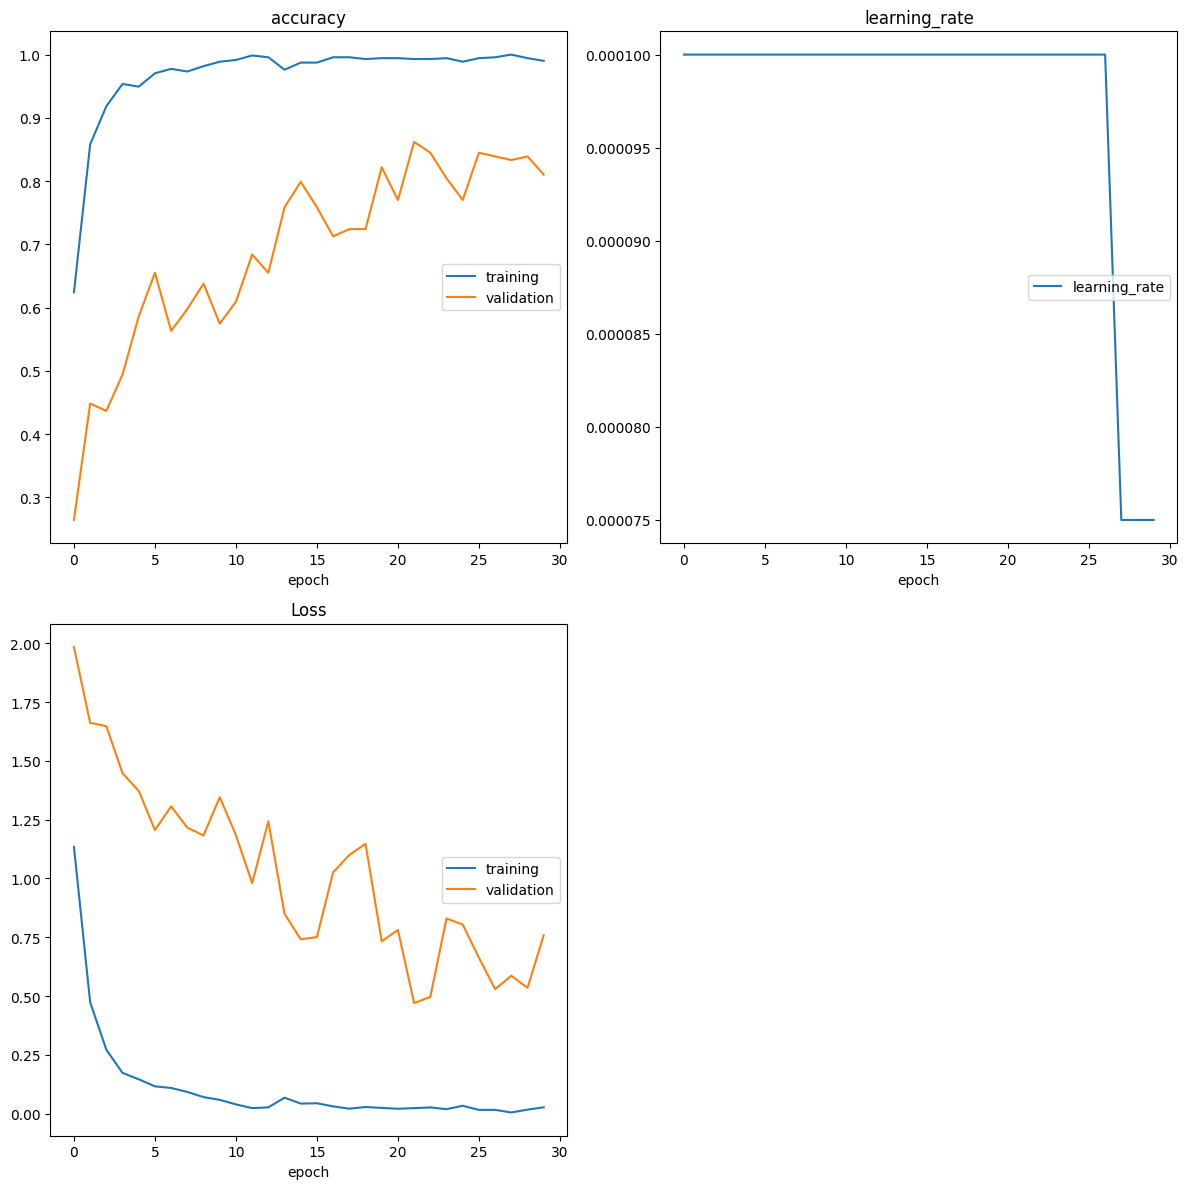

accuracy
	training         	 (min:    0.624, max:    1.000, cur:    0.990)
	validation       	 (min:    0.264, max:    0.862, cur:    0.810)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.005, max:    1.134, cur:    0.027)
	validation       	 (min:    0.470, max:    1.984, cur:    0.758)
23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9933 - loss: 0.0224 - val_accuracy: 0.8103 - val_loss: 0.7583 - learning_rate: 7.5000e-05
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 22.


In [11]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    callbacks=[early_stop,reduce_lr, checkpoint, PlotLossesKeras()])

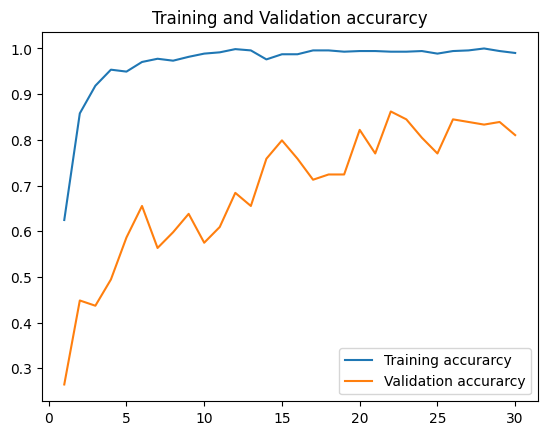

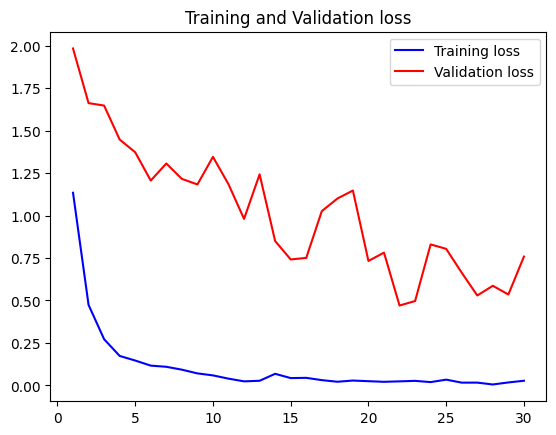

CPU times: user 443 ms, sys: 208 ms, total: 650 ms
Wall time: 419 ms


In [12]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_VGG19_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()